## working with projections

We have been using [fast_hist](https://github.com/phaustin/e582/blob/f8c2e8cc8dce36c9852ca99ccfe19250d1405b50/a301lib/geolocate.py#L124)
and [fast_avg](https://github.com/phaustin/e582/blob/f8c2e8cc8dce36c9852ca99ccfe19250d1405b50/e582lib/geolocate.py#L283) to map our MODIS
level 1b pixels to a uniform lat/lon grid for plotting.  There is one big problem with this approach:
the actual ground spacing of a uniform longitude grid changes drastically from the equator to the poles, because
longitude lines converge.   A better approach is to do the following:

1) pick a map projection

2) define an x,y in grid in meters based on that projection

3) resample the satellite data onto that grid

4) save it as a geotiff file, which maintains all the information about the projection we used


## First, get channel 8 (blue) and the lat/lon files 

Note that channel 8 is at index 0 in the EV_250_Aggr1km_RefSB dataset

https://modis.gsfc.nasa.gov/about/specifications.php

In [1]:
import h5py
from e582lib.geolocate import find_corners
import numpy as np
import pyproj
import pyresample
from pyresample import kd_tree,geometry
from pyresample.plot import area_def2basemap
from matplotlib import pyplot as plt
from e582utils.modismeta_read import parseMeta
from e582utils.data_read import download

data_name='MYD021KM.A2016224.2100.006.2016225153002.h5'
download(data_name)
geom='MYD03.A2016224.2100.006.2016225152335.h5'
download(geom)

index=0
my_name = 'EV_250_Aggr1km_RefSB'
with h5py.File(data_name,'r') as h5_file:
    chan1=h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][my_name][index,:,:]
    scale=h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][my_name].attrs['reflectance_scales'][...]
    offset=h5_file['MODIS_SWATH_Type_L1B']['Data Fields'][my_name].attrs['reflectance_offsets'][...]
chan1_calibrated =(chan1 - offset[index])*scale[index]
    
with h5py.File(geom) as geo_file:
    lon_data=geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields']['Longitude'][...]
    lat_data=geo_file['MODIS_Swath_Type_GEO']['Geolocation Fields']['Latitude'][...]



MYD021KM.A2016224.2100.006.2016225153002.h5 already exists
and is 159039295 bytes
will not overwrite


MYD03.A2016224.2100.006.2016225152335.h5 already exists
and is 40795456 bytes
will not overwrite



### Next use a new function to get the corner points and the center lat and lon from MODIS metadata

The function is [parseMeta](https://github.com/phaustin/e582/blob/b3ea180566d2fd3acd5ea3a246d6c0eb6ae14a41/e582utils/modismeta_read.py#L106) and you
can treat it as a black box unless you're interested in how regular expressions work in python. It does
the same thing that [find_corners](https://github.com/phaustin/e582/blob/b3ea180566d2fd3acd5ea3a246d6c0eb6ae14a41/e582lib/geolocate.py#L16) does, but
skips the calculation, since NASA has already computed everything we need more accurately.

In [2]:
corners=parseMeta(data_name)
proj_id = 'laea'
datum = 'WGS84'
lat_0 = '{lat_0:5.2f}'.format_map(corners)
lon_0= '{lon_0:5.2f}'.format_map(corners)
lon_bbox = [corners['min_lon'],corners['max_lon']]
lat_bbox = [corners['min_lat'],corners['max_lat']]

### 1.  Pick a map projection

The program that resamples modis data onto a particular projected grid is
[pyresample](http://pyresample.readthedocs.io/en/latest/index.html).   I'll resample the swath
using a [lambert azimuthal equal area](http://matplotlib.org/basemap/users/laea.html) projection

The output will be a 2500 x 2500 array called result which has the channel 1 data resampled onto
a grid centered at the lat_0,lon_0 center of the swath.  The values will be determined by averaging the nearest
neighbors to a particular cell location, using a zone of influence with a radius of 5000 meters, and
a [kd-tree](https://en.wikipedia.org/wiki/K-d_tree)

The next cell puts the projection into a structure that pyresample understands, and does the resampling

### 2. and 3.: define an x,y grid and resample onto it

In [3]:
area_dict = dict(datum=datum,lat_0=lat_0,lon_0=lon_0,
                proj=proj_id,units='m')
prj=pyproj.Proj(area_dict)
x, y = prj(lon_bbox, lat_bbox)
xsize=2200
ysize=2500
area_id = 'granule'
area_name = 'modis swath 5min granule'
area_extent = (x[0], y[0], x[1], y[1])
area_def = geometry.AreaDefinition(area_id, area_name, proj_id, 
                                   area_dict, xsize,ysize, area_extent)
swath_def = geometry.SwathDefinition(lons=lon_data, lats=lat_data)
result = kd_tree.resample_nearest(swath_def, chan1_calibrated.ravel(),
                                  area_def, radius_of_influence=5000, nprocs=2)
print(area_def)

Area ID: granule
Name: modis swath 5min granule
Projection ID: laea
Projection: {'datum': 'WGS84', 'lat_0': '46.13', 'lon_0': '-122.60', 'proj': 'laea', 'units': 'm'}
Number of columns: 2200
Number of rows: 2500
Area extent: (-1695072.2056542288, -1029745.799695021, 1123075.211797113, 1361928.7371632326)


### plot the reprojected image

pyresample can take its projection structure and turn it into a basemap instance using
[area_def2basemap](https://github.com/pytroll/pyresample/blob/3fce7fc832e0b86369d452d504a21fb65205435c/pyresample/plot.py#L91)

This works because both pyresample and basemap use the same underlying projection code called
[pyproj](https://github.com/jswhit/pyproj).  

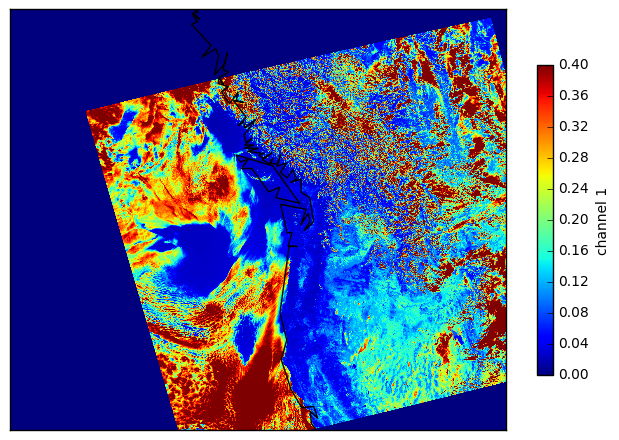

In [4]:
plt.close('all')
fig,ax = plt.subplots(1,1, figsize=(8,8))
bmap=area_def2basemap(area_def,ax=ax,resolution='c')
num_meridians=180
num_parallels = 90
vmin=None; vmax=None
col = bmap.imshow(result, origin='upper', vmin=0, vmax=0.4)
label='channel 1'
bmap.drawmeridians(np.arange(-180, 180, num_meridians),labels=[True,False,False,True])
bmap.drawparallels(np.arange(-90, 90, num_parallels),labels=[False,True,True,False])
bmap.drawcoastlines()
fig.colorbar(col, shrink=0.5, pad=0.05).set_label(label)
fig.canvas.draw()
plt.show()

## Why is this image clipped on the right?



Note that I made a mistake above, in this sequence of commands:

    x, y = prj(lon_bbox, lat_bbox)
    xsize=2200
    ysize=2500
    area_id = 'granule'
    area_name = 'modis swath 5min granule'
    area_extent = (x[0], y[0], x[1], y[1])
    
What was my mistake?  I first found the corners in lat/lon coordinates.  Here the are

In [10]:
lon_bbox,lat_bbox

([-141.303105914931, -103.90324724207601],
 [35.1191874065048, 57.1392579098083])

This sets the lower left corner at [-141.3,35.1] and the upper right corner at [-103.9, 57.1].  Translated to x,y coordinates this produces the bounding box.   What I needed to do, however is to get the x coordinate of longitude 
-103.9 deg West at a latitude of 35.1 degrees, not a latitude of 57.1 degrees.  The correct order that does this is:

    x, y = prj(corners['lon_list'], corners['lat_list'])
    #
    # find the corners in map space
    #
    minx,maxx=np.min(x),np.max(x)
    miny,maxy=np.min(y),np.max(y)
    #
    # back transform these to lon/lat
    #
    llcrnrlon,llcrnrlat=prj(minx,miny,inverse=True)
    urcrnrlon,urcrnrlat=prj(maxx,maxy,inverse=True)
    
That is, I need to find the largest and smallest x and y coordinates, then backtransform those to latitude and longitude, so that the upper right corner uses the y from the upper right corner but the x from the lower right corner to set the map frame.   You can see this in action in resample2.ipynb

### 4. Write ths out as a geotiff file

Here's how to create a tif file that saves all of the projection infomation along with
the gridded raster image of channel 1

In [5]:
from osgeo import gdal, osr
raster = gdal.GetDriverByName("GTiff")
gformat = gdal.GDT_Float32
channel=result.astype(np.float32)
opacity=0
fill_value=0
g_opts=[]
height,width=result.shape
tiffile='test.tif'
dst_ds = raster.Create(tiffile,width,height,
                       1,gformat,g_opts)
area=area_def
adfgeotransform = [area.area_extent[0], area.pixel_size_x, 0,
                   area.area_extent[3], 0, -area.pixel_size_y]
dst_ds.SetGeoTransform(adfgeotransform)
srs = osr.SpatialReference()
srs.ImportFromProj4(area.proj4_string)
srs.SetProjCS(area.proj_id)
srs = srs.ExportToWkt()
dst_ds.SetProjection(srs)
dst_ds.GetRasterBand(1).WriteArray(channel)
del dst_ds

The gdal package has some scripts to dump the details about the tif file and the srs ("spatial reference system")

In [6]:
!gdalinfo test.tif

Driver: GTiff/GeoTIFF
Files: test.tif
Size is 2200, 2500
Coordinate System is:
PROJCS["laea",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",46.13],
    PARAMETER["longitude_of_center",-122.6],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]
Origin = (-1695072.205654228804633,1361928.737163232639432)
Pixel Size = (1280.976098841518933,-956.669814743301458)
Metadata:
  AREA_OR_POINT=Area
Image Structure Metadata:
  INTERLEAVE=BAND
Corner Coordinates:
Upper Left  (-1695072.206, 1361928.737) (150d 8' 5.58"W, 55d35'36.58"N)
Lower Left  (-1695072.206,-1029745.800) (141d18'11.18"W, 35d 7' 9.07"N)

In [7]:
!gdalsrsinfo test.tif


PROJ.4 : '+proj=laea +lat_0=46.13 +lon_0=-122.6 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs '

OGC WKT :
PROJCS["laea",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Lambert_Azimuthal_Equal_Area"],
    PARAMETER["latitude_of_center",46.13],
    PARAMETER["longitude_of_center",-122.6],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]]]



### Read the projection data back in from the tif file using gdal:

In [8]:
import gdal
from gdalconst import GA_ReadOnly
data = gdal.Open(tiffile, GA_ReadOnly)
geoTransform = data.GetGeoTransform()
minx = geoTransform[0]
maxy = geoTransform[3]
maxx = minx + geoTransform[1] * data.RasterXSize
miny = maxy + geoTransform[5] * data.RasterYSize
print('\nhere are the projected corners of the x,y raster\n{}'.format([minx, miny, maxx, maxy]))
print('\nhere are the attributes of the data instance:\n{}\n'.format(dir(data)))
data = None


here are the projected corners of the x,y raster
[-1695072.2056542288, -1029745.799695021, 1123075.2117971128, 1361928.7371632326]

here are the attributes of the data instance:
['AddBand', 'BeginAsyncReader', 'BuildOverviews', 'CommitTransaction', 'CopyLayer', 'CreateLayer', 'CreateMaskBand', 'DeleteLayer', 'EndAsyncReader', 'ExecuteSQL', 'FlushCache', 'GetDescription', 'GetDriver', 'GetFileList', 'GetGCPCount', 'GetGCPProjection', 'GetGCPs', 'GetGeoTransform', 'GetLayer', 'GetLayerByIndex', 'GetLayerByName', 'GetLayerCount', 'GetMetadata', 'GetMetadataDomainList', 'GetMetadataItem', 'GetMetadata_Dict', 'GetMetadata_List', 'GetProjection', 'GetProjectionRef', 'GetRasterBand', 'GetStyleTable', 'GetSubDatasets', 'GetTiledVirtualMem', 'GetTiledVirtualMemArray', 'GetVirtualMem', 'GetVirtualMemArray', 'RasterCount', 'RasterXSize', 'RasterYSize', 'ReadAsArray', 'ReadRaster', 'ReadRaster1', 'ReleaseResultSet', 'RollbackTransaction', 'SetDescription', 'SetGCPs', 'SetGeoTransform', 'SetMetada